In [4]:
# filename: minianalysis__cognate_variables.py
# 
# description: Runs models as specified originally and again after replacing a central variable by a cognate variable.
# It compares regressions on what was then the new data vs same regressions on future waves
# 
# inputs:
# 
# outputs:
# 
# @author: Misha
# 

from __future__ import division

import matplotlib.pyplot as plt

import pandas as pd
import pickle

import sys
sys.path.append('../')    
import GSSUtility as GU

import numpy as np
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter
from collections import defaultdict

import seaborn as sb
custom_style = {'axes.facecolor': 'white',
                'grid.color': '0.15',
                'grid.linestyle':'-.'}
sb.set_style("darkgrid", rc=custom_style)

In [11]:
%rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
reload(GU)

<module 'GSSUtility' from '../GSSUtility.py'>

In [ ]:
if __name__ == "__main__":    

    try:
        %rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
        reload(GU)
    except:
        pass
    
    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
#     tempCognateOutput = open(pathToData + 'tempCognateOutput.txt', 'w')
    
    # contains for storing (variable, cognate) tuples in order to see what substitutions
    #i'm most commonly making
    variableCognateTuples = []
    
    # define the storage containers for outputs
    group1 = 'original model'
    group2 = 'cognate model'   
    groups = [group1, group2]
    outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
                'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']
    output = defaultdict(dict)
    output['metadata'] = {'article_id':[]}
    for group in groups:
        for outcome in outcomes:
            output[group][outcome] = []
            
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=False, \
                                      centralIVs=True, linearModels=False) 
    
    print 'Articles to use:', len(articlesToUse)

#     for article in random.sample(articlesToUse, 200):
    for article in articlesToUse:
    #for article in [a for a in articleClasses if a.articleID == 6755]:
    
        print '\n\n\==============================\nProcessing article:', article.articleID

        # let's see if this article is suitable for cognates analysis:
        originalLHS = article.IVs + article.controls
        identifyCognatesReturns = GU.identifyCognates(dataCont, originalLHS, article.centralIVs, article.GSSYearsUsed, corrThreshold=0.6 )        
        if not identifyCognatesReturns: 
            print 'No suitable cognates. Skipping.'            
            continue        
        else: 
            cIV, cognate, GSSYearsWithCognate = identifyCognatesReturns
            
        # if we got this far, then this article does have suitable cognates, so let's estimate models       
        # Now let's estimate the models
        for DV in article.DVs:            
            
            if cognate == DV: continue # sometimes the cognate suggested by GU.identifyCognates is the DV
                
            for year in GSSYearsWithCognate:        

                # group 2 models (with cognates)
                print 'Running cognate models'
                
                cognateLHS = originalLHS[:] # the "[:]" makes a deep copy ?
                cognateLHS.remove(cIV)
                cognateLHS.append(cognate) # need to put it in list otherwise it treats each letter as an element
#                 print 'Substituting', cIV, 'with cognate', cognate
                #time.sleep(2)
                #raw_input('Press Enter')                
                
                result_cog = GU.runModel(dataCont, year, DV, cognateLHS)          
                if not result_cog: continue # results will be None if the formula cant be estimated
#                 print DV, '~', cognateLHS, 'on year', year
                 
                # RUN MODELS FROM GROUP 1 ############################################  
                # group 1
                print 'Running original models.'
                
#                 # make sure cIV is last in the list of variables
                originalLHS.remove(cIV)
                originalLHS.append(cIV) 
    
                result_orig = GU.runModel(dataCont, year, DV, originalLHS)                     
                if not result_orig: continue # results will be None if the formula cant be estimated

                results = [result_orig, result_cog]
                
                # new change, 2015-01-05
                # THIS BLOCK OF CODE BELOW IS ADDED FROM 'MINIANALYSIS__models_on_next_year, 
                centralVars = []            
                for civ in article.centralIVs:
                    if 'standardize(%s, ddof=1)' % (civ) in results[0].params.index:
                        centralVars.append('standardize(%s, ddof=1)' % (civ))
                    else: 
                        for col in results[0].params.index:
                            if 'C(' + civ + ')' in col:
                                centralVars.append(col)          
                                
                # the condition below means that i don't care about models in which orig var isn't stat. sig.
                # A reason for this condition is that if this central variable isn't significant in the original model
                # then the goal of the article may've been to show that this variable DOESN'T matter. In such a "negative" case,
                # what does replacing it with a cognate accomplish?

                # old condition below
#                 if result_orig.pvalues[-1] > 0.05: continue
                # new condition below
#                 if np.all(results[0].pvalues[centralVars] > 0.05): 
#                     print 'All "central" IVs are p > 0.05. Skipping.'
#                     continue                
                
                # Checks on which results to record                
                if len(result_cog.params) != len(result_orig.params):
                    print 'The number of variables in original model is different from the number in cognate model. Skipping.'                    
                    continue

                    
# ###########################################################################################                
# new way of saving results
# new change, 2015-01-05
# THIS BLOCK OF CODE BELOW IS ADDED FROM 'MINIANALYSIS__models_on_next_year,                    
                for i in range(2):                 
                    output[groups[i]]['Rs'].append(results[i].rsquared) 
                    output[groups[i]]['adjRs'].append(results[i].rsquared_adj) 
                    output[groups[i]]['propSig'].append(float(len([p for p in results[i].pvalues[1:] if p < 0.05]))/len(results[i].params[1:])) 
                    output[groups[i]]['paramSizesNormed'].append(np.mean(results[i].params[1:].abs())) 
                    output[groups[i]]['pvalues'].append(np.mean( results[i].pvalues[1:]))
                    output[groups[i]]['numTotal'].append( 1 ) #divide by len of R^2 array to get a mean of variables estimated PER model                           

                    if len(centralVars)>0:
                        output[groups[i]]['pvalues_CentralVars'].append(np.mean(results[i].pvalues[centralVars]))               
                        output[groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) \
                                                                /len(results[i].params[centralVars])) 
                        output[groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars].abs()))                
                    else:
                        output[groups[i]]['pvalues_CentralVars'].append(nan)               
                        output[groups[i]]['propSig_CentralVars'].append(nan) 
                        output[groups[i]]['paramSizesNormed_CentralVars'].append(nan)                
                
                output['metadata']['article_id'].append(article.articleID)    

pickle.dump(output, open('output.pickle', 'w'))
# ########################################################################################                
# ## this is the old ways of saving results.. now i'm doing it the way "models_on_next_year" does it
    
#                 for i in range(2):
#                     # save the results                   
#                     td[groups[i]]['Rs'].append(results[i].rsquared)
#                     td[groups[i]]['adjRs'].append(results[i].rsquared_adj)
#                     td[groups[i]]['numTotal'] += len(results[i].params[1:])
#                     td[groups[i]]['numSig'] += float(len([p for p in results[i].pvalues[1:] if p < 0.05])) # start at 1 because don't want to count the constant
#                     td[groups[i]]['paramSizesNormed'].append(abs(results[i].params[-1])) # get the absolute value of the standardized coefficients and take the mean 
#                     td[groups[i]]['pvalues'].append(results[i].pvalues[-1])
               
#                     td[groups[i]]['pvalues_CentralVars'].append(np.mean(results[i].pvalues[centralVars]))               
#                     td[groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) \
#                                                             /len(results[i].params[centralVars])) 
#                     td[groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars].abs()))                

                

# # # #                 print >> tempCognateOutput, 'Orig:\t', cIV, '\t\tCogn:\t', cognate, '\t\t Coeffs:\t', results.params[-1], results.pvalues[-1],resultsCognate.params[-1], resultsCognate.pvalues[-1] 
            
            
            
#             # The change I'm making is that the block below is now within the for loop
#             # of "for DV in article.DVs". So I'm averaging over years but not DVs   
            
#             # if an article's model isn't run on both group 1 and group 2, skip it        
#             if td[group1]['numTotal'] == 0 or td[group2]['numTotal'] == 0: continue
          
#             variableCognateTuples.append((cIV, cognate))
#             for group in groups:      
#                 output[group]['Rs'].append( np.mean(td[group]['Rs'])) 
#                 output[group]['adjRs'].append(np.mean( td[group]['adjRs'])) 
#                 output[group]['propSig'].append( td[group]['numSig']/td[group]['numTotal']) 
#                 output[group]['paramSizesNormed'].append(np.mean( td[group]['paramSizesNormed'])) 
#                 output[group]['pvalues'].append(np.mean( td[group]['pvalues']))
#                 output[group]['numTotal'].append(td[group]['numTotal'] / len(td[group]['Rs'])) #divide by len of R^2 array to get a mean of variables estimated PER model                           

#                 output[group]['pvalues_CentralVars'].append(np.mean(td[group]['pvalues_CentralVars']))               
#                 output[group]['propSig_CentralVars'].append(np.mean(td[group]['propSig_CentralVars'])) 
#                 output[group]['paramSizesNormed_CentralVars'].append(np.mean(td[group]['paramSizesNormed_CentralVars']))                

#             output['metadata']['article_id'].append(article.articleID)   
        


#     print 'TTests'
#     for outcome in outcomes:
#         print 'Means of group1 and group2:', np.mean(output[group1][outcome]), np.mean(output[group2][outcome]), 'Paired T-test of ' + outcome, ttest_rel(output[group1][outcome], output[group2][outcome])

#     tempCognateOutput.close()    

# <markdowncell>

# Create a Pandas DataFrame of the output
# --


In [22]:
# import pickle
# group1 = 'original model'
# group2 = 'cognate model'   
# groups = [group1, group2]
# outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
#             'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']



In [25]:
%matplotlib inline
output = pickle.load(open('output.pickle'))
group1 = 'original model'
group2 = 'cognate model'   
groups = [group1, group2]
outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
            'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

In [26]:
df_output = pd.DataFrame(index=np.arange(len(output[group1]['propSig'])), columns=pd.MultiIndex.from_product([groups, outcomes]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[gp, outcome] = output[gp][outcome]
df_output.index = output['metadata']['article_id']
del df_output[group1, 'numTotal']
del df_output[group2, 'numTotal']
print 'Using %f models from %f articles' % (len(df_output), len(df_output.index.unique()))
# df_output.to_pickle('df_output.pickle')

Using 4413.000000 models from 307.000000 articles


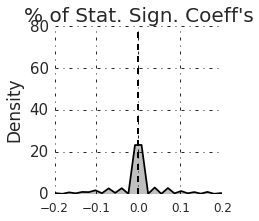

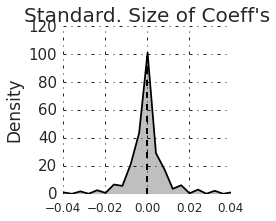

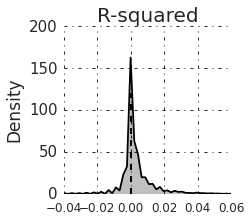

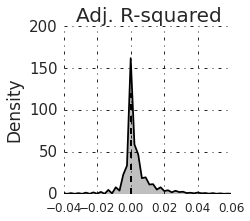

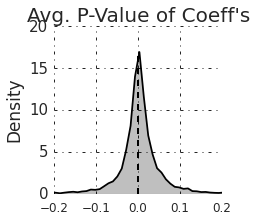

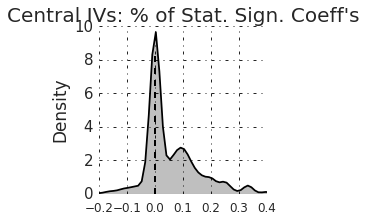

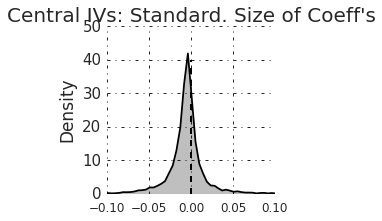

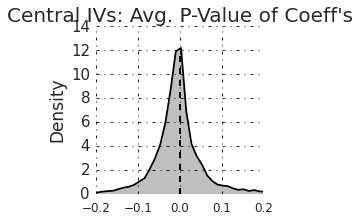

In [22]:
# %matplotlib inline
# #Plot outcomes - (new) distribution of differences approach
# df_output = pd.read_pickle('df_output.pickle')
# <codecell>

outcomeMap = {'propSig':"% of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
              'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Central IVs: % of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Central IVs: Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Central IVs: Avg. P-Value of Coeff's"}

outcomeXlimits = {'propSig':(-.2,.2), 
              'paramSizesNormed':(-.04,.04),
              'Rs':(-.04, .06), 
              'adjRs':(-.04, .06),
              'pvalues':(-.2, .2),
              'propSig_CentralVars':(-.2, .4),
              'paramSizesNormed_CentralVars':(-.1,.1), 
              'pvalues_CentralVars':(-.2, .2)}

outcomeYlimits = {'propSig':80, 
              'paramSizesNormed':100,
              'Rs':120, 
              'adjRs':120,
              'pvalues':17,
              'propSig_CentralVars':8.5,
              'paramSizesNormed_CentralVars':40, 
              'pvalues_CentralVars':11.5}

for outcome in outcomes:
    plt.figure(figsize=(3,3))
    if outcome=='article_id': continue
    if outcome=='numTotal':continue

    plt.xticks(fontsize=12)
    plt.locator_params(nbins=7)
    plt.yticks(fontsize=15)
    plt.ylabel('Density', fontsize=17)
    plt.title(outcomeMap[outcome], fontsize=20)
    plt.xlim(outcomeXlimits[outcome])    
    
    sb.kdeplot((df_output[group1, outcome] - df_output[group2, outcome]), 
                color='black', legend=False, shade=True)
    plt.plot([0,0], [0,outcomeYlimits[outcome]], '--', color='black', linewidth=2)
    
    plt.savefig('images/cognate-differences--' + outcome + '.png', bbox_inches='tight')
#     break

# <markdowncell>

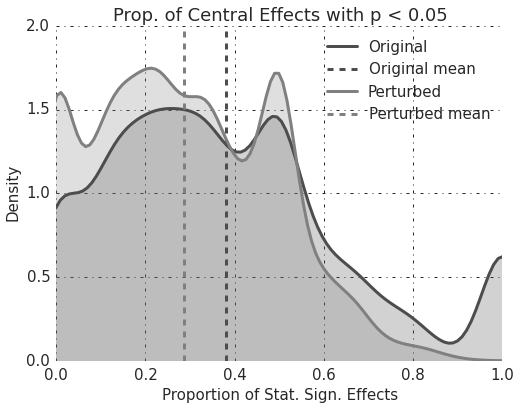

In [69]:
# ONE EXAMPLE OF DIFFERENCES IN DISTRIBUTION: PROP OF STAT. SIGN. EFFECTS FOR CENTRAL VARS
plt.figure(figsize=(8,6))
sb.kdeplot(df_output[group1, 'propSig_CentralVars'], color='0.3', shade=True, label='Original', linewidth=3)
plt.plot([df_output[group1, 'propSig_CentralVars'].mean()]*2, [0,2], '--', c='0.3', linewidth=3, label='Original mean')
sb.kdeplot(df_output[group2, 'propSig_CentralVars'], color='0.5', shade=True, label='Perturbed', linewidth=3)
plt.plot([df_output[group2, 'propSig_CentralVars'].mean()]*2, [0,2], '--', c='0.5', linewidth=3, label='Perturbed mean')
plt.legend(loc='best', fontsize=15)
plt.title('Prop. of Central Effects with p < 0.05', fontsize=18)
plt.xlabel('Proportion of Stat. Sign. Effects', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.xlim(0, 1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('images/cognate-example-of-differences-in-distributions-prop-sign-of-central-effects.png', bbox_inches='tight', dpi=150)

In [10]:
# # #Plot outcomes - (old) bar chart approach
# %matplotlib inline

# plt.figure(figsize=(14,8))
# outcomesToUse = df_output[group1].columns
# indices = np.arange(len(outcomesToUse))
# width = 0.35
# error_config = {'ecolor': '0.3'}

# axes = plt.figure().add_subplot(111)
# rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='0.75', 
#              yerr=2*df_output[group1].std()/np.sqrt(len(df_output[group1])),
#              error_kw=error_config) #this is not very relevant because we're not comparing independent groups
# rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='0.5', 
#              yerr=2*df_output[group2].std()/np.sqrt(len(df_output[group2])),
#              error_kw=error_config)

# # title, legend, etc
# plt.title('Original vs. Cognate Models', fontsize=18)
# plt.legend((rects1[0], rects2[0]), ('Original models', 'Cognate models'), fontsize=15)
# # legend((rects1[0], rects2[0]), ('Original models', 'Cognate models'), fontsize=15)
# plt.xlim((-1*width, len(outcomesToUse)))

# # tick labels
# # a = outcomesToUse
# a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
#      '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
# axes.set_xticks(indices+width)
# axes.set_xticklabels(a, rotation=90, fontsize=15)

# # label the bars with the difference between them
# diffs = (df_output[group1] - df_output[group2]).mean().values
# def autolabel(rects):
#     # attach some text labels
#     for i, rect in enumerate(rects):
#         height = rect.get_height()
#         if i!=7 and i!=4:
#             axes.text(rect.get_x()+width, 1.03*height, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
#         else: # this is for the p-value label, which has gone up
#             axes.text(rect.get_x()+width, 1.03*height+0.05, '%0.3f'%diffs[i],
#                     ha='center', va='bottom', fontsize=15)
# autolabel(rects1)

# # plt.figure(figsize=(6,5))
# # (df_output[group1]['paramSizesNormed'] - df_output[group2]['paramSizesNormed']).plot(kind='kde')
# # plt.plot([0,0], [0,20], '--')
# # plt.title('Differences in Stand. Coeff. Size. between orig. and cognate')

# # # <codecell>

# # mn= np.mean((df_output[group1, 'Rs'] - df_output[group2, 'Rs']).values)
# # sd= np.std((df_output[group1, 'Rs'] - df_output[group2, 'Rs']).values)
# # print mn, sd, mn/(sd/np.sqrt(df_output.shape[0]))

# # <markdowncell>

In [23]:
# #temp fix to convert proportions into percentages
# for group in [group1, group2]:
#     for o in ['propSig', 'propSig_CentralVars']:
#         df_output[group, o] = df_output[group, o]/100

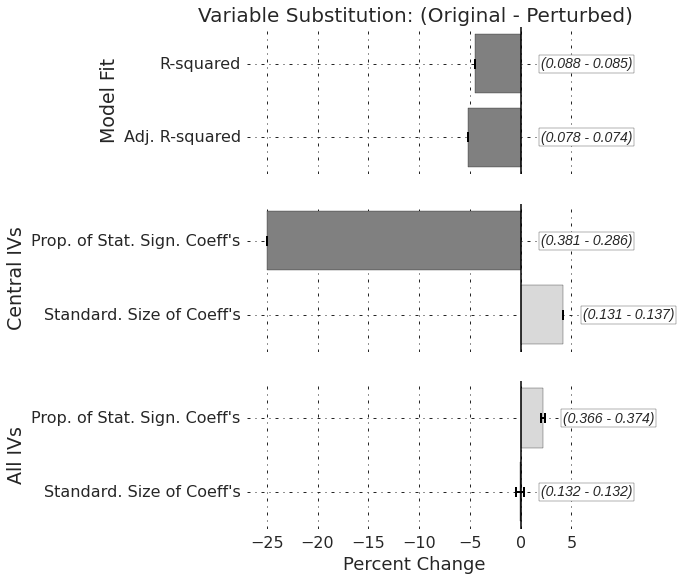

In [68]:
%matplotlib inline

# fig = plt.figure(figsize=(6,9))
outcomesToUse = [u'adjRs',
                 u'Rs',
                 u'paramSizesNormed_CentralVars',                
                 u'propSig_CentralVars', 
                 u'paramSizesNormed',
                 u'propSig']

outcomeMap = {'propSig':"Prop. of Stat. Sign. Coeff's", 
              'paramSizesNormed':"Standard. Size of Coeff's",
              'Rs':'R-squared', 
              'adjRs':'Adj. R-squared',
#               'pvalues':"Avg. P-Value of Coeff's",
              'propSig_CentralVars':"Prop. of Stat. Sign. Coeff's",
              'paramSizesNormed_CentralVars':"Standard. Size of Coeff's", 
              'pvalues_CentralVars':"Avg. P-Value of Coeff's"}

# indices = [1,2,4,5,7,8]
width = 0.5
error_config = dict(ecolor='0', lw=2, capsize=5, capthick=2)

diffs = [100*(df_output[group2, outcome] - df_output[group1, outcome]).mean()/df_output[group1, outcome].mean() for outcome in outcomesToUse]
diffs_strings = ['(%0.3f - %0.3f)' % (df_output[group1, outcome].mean(), df_output[group2, outcome].mean()) 
                 for outcome in outcomesToUse]
diffs = np.array(diffs)

# naive SES
# ses = [(df_output[group1, outcome] - df_output[group2, outcome]).std()/np.sqrt(len(df_output)) for outcome in outcomesToUse]

# clustered SES
clusteredSES = []
article_ids = np.array(list(df_output.index)) 
for outcome in outcomesToUse:
    diff = 100*(df_output[group2, outcome] - df_output[group1, outcome])
    mask = ~np.isnan(np.array(diff))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diff[mask], 'x':[1]*len(diff[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
    clusteredSES.append(result_clustered.HC0_se[0])
clusteredSES = np.array(clusteredSES)

colors = ['0.5' if el < 0 else '0.85' for el in diffs]

# plt.barh(indices, diffs, xerr=2*np.array(clusteredSES), align='center', color=colors, error_kw=error_config)
# axes.set_yticks(indices)
# axes.set_yticklabels([outcomeMap[o] for o in outcomesToUse], fontsize=17)

f, axarr = plt.subplots(3, sharex=True, figsize=(6,9))
                        
for i in range(3):
    # bars
    xerr = 2*clusteredSES[i*2:i*2+2] / diffs[i*2:i*2+2] # i am dividing here because we want the SEs to be on the percent-change scale, not raw scale
    boxes = axarr[i].barh([0,1], diffs[i*2:i*2+2], xerr=xerr, 
             align='center', color=colors[i*2:i*2+2], error_kw=error_config)
   
    # annotate boxes: raw means
    box0_xcoord = boxes[0].get_bbox().get_points()[1,0] + 2 # the indices here mean get the x-coord of 2nd box corner
    box1_xcoord = boxes[1].get_bbox().get_points()[1,0] + 2

    axarr[i].text(box0_xcoord, 0, diffs_strings[i*2], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')
    axarr[i].text(box1_xcoord, 1, diffs_strings[i*2+1], fontsize=14,
                 verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=1), style='italic')

    #labels for y-axis
    axarr[i].set_yticks([0,1])
    axarr[i].set_yticklabels([outcomeMap[o] for o in outcomesToUse[i*2:i*2+2]], fontsize=16)
    axarr[i].plot([0,0], [-0.5,1.5], linewidth=2, c='black', alpha=.75)    
 
    
axarr[0].set_title('Variable Substitution: (Original - Perturbed)', fontsize=20)
axarr[0].set_ylabel('Model Fit', fontsize=19)
axarr[1].set_ylabel('Central IVs', fontsize=19)
axarr[2].set_ylabel('All IVs', fontsize=19)
axarr[2].set_xlabel('Percent Change', fontsize=18)
plt.xticks(fontsize=16)
plt.xlim(-27,6)

# plt.title('Original vs. Cognate Models', fontsize=20)
# plt.xlabel('% change from original to cognate', fontsize=17)
# plt.xticks(fontsize=15)

# plt.plot([0,0], [-0.5,7.5], linewidth=2, c='black', alpha=.75)

plt.savefig('images/cognate--original-minus-perturbed.png', bbox_inches='tight', dpi=150)

In [60]:
box = rects[0].get_bbox()
box.

0.0

In [124]:
# Perform t-tests and Tests using *clustered errors*
# --
# 
# 1. Perform related-sample t-test (samples must be of equal lengths)
# 
# 2. Perform independent samples t-test (just for kicks, to see how big our effects are)
# 
# 3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html
# 
# Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
# "This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
# source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm
# 
# Note
# --
# For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
# fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.
# 
# Outcome
# --
# The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?

# <codecell>
try: outcomes.remove('numTotal')
except: pass

# <codecell>

# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_1samp
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', df_output[group1, outcome].mean()
    print 'Mean after substitution:', df_output[group2, outcome].mean()
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    article_ids = np.array(list(df_output.index)) 
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    mask = ~np.isnan(np.array(diffs))
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs[mask], 'x':[1]*len(diffs[mask])})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                                    cov_kwds=dict(groups=article_ids[mask]))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

# <codecell>

df_output[group1, outcome]

# <codecell>


# <codecell>

pd.MultiIndex.from_product([outcomes, ['orig. models', 'cognate models']])

# <markdowncell>

# #How many models now have p > 0.05?

# <codecell>

print 'count:', df_output[group2, 'pvalues'][df_output[group2, 'pvalues'] > 0.05].shape[0]
print 'total:', df_output.shape[0]
print 'percent:', df_output[group2, 'pvalues'][df_output[group2, 'pvalues'] > 0.05].shape[0]/ df_output.shape[0]

propSig
Mean before substitution: 0.348962946843
Mean after substitution: 0.35492943673
Related samples t-test p-value: 0.000197
clustered errors p-value: 0.02

paramSizesNormed
Mean before substitution: 0.142483082205
Mean after substitution: 0.143310033828
Related samples t-test p-value: 9.8e-05
clustered errors p-value: 0.104

Rs
Mean before substitution: 0.106286184579
Mean after substitution: 0.101797165866
Related samples t-test p-value: 0.0
clustered errors p-value: 0.0

adjRs
Mean before substitution: 0.094946744107
Mean after substitution: 0.0904192359773
Related samples t-test p-value: 0.0
clustered errors p-value: 0.0

pvalues
Mean before substitution: 0.304953672551
Mean after substitution: 0.300841079735
Related samples t-test p-value: 2.7e-05
clustered errors p-value: 0.015

propSig_CentralVars
Mean before substitution: 0.379543433548
Mean after substitution: 0.294801374464
Related samples t-test p-value: 0.0
clustered errors p-value: 0.0

paramSizesNormed_CentralVars
Mea

In [133]:
print outcome
print result_clustered.HC0_se

pvalues_CentralVars
x    0.001444
dtype: float64
